In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

### Data Loading

In [2]:
df = pd.read_excel("premiums_data.xlsx")
df.shape

(50000, 13)

In [3]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

Here we can see that few of the columns like 'Number of Dependants', 'Medical History' ,... have space in their names, so we have to replace it with '_'

In [5]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [6]:
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053


In [7]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    50000 non-null  int64 
 1   gender                 50000 non-null  object
 2   region                 50000 non-null  object
 3   marital_status         50000 non-null  object
 4   number_of_dependants   50000 non-null  int64 
 5   bmi_category           50000 non-null  object
 6   smoking_status         49989 non-null  object
 7   employment_status      49998 non-null  object
 8   income_level           49987 non-null  object
 9   income_lakhs           50000 non-null  int64 
 10  medical_history        50000 non-null  object
 11  insurance_plan         50000 non-null  object
 12  annual_premium_amount  50000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 5.0+ MB


Smoking_Status, Employment_Status and Income_Level has null values and all these categorical values .

### Handling Null Values

In [8]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

AT me, the BEST cleaning method is : Fill missing values with MODE (most frequent category). As for categorical data, mode imputation keeps 
distribution realistic . Missing counts are extremely small -> mode filling is safe .

But my sir suggested to drop this 'na' values as if we see the shape, we have 50k rows so in comparison with 50k, 11,13 is nothing

Dropping rows with such tiny missing counts is 100% acceptable and often even cleaner than imputing. We have: 11 missing, 2 missing and 13 missing
Total = 26 rows missing out of 50,000 rows → only 0.052%. 
      This won’t affect our model at all. So yes, we will drop them.

In [9]:
df.dropna(inplace=True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [10]:
df.shape

(49976, 13)

In [11]:
df.duplicated().sum()

np.int64(0)

Right now, we don't have duplicates rows, but in case maybe in future our company change the data give us some additional info. in that case we should have that drop duplicate function, so lets code that

In [12]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,49976.0,34.591764,15.000378,18.0,22.00,31.0,45.0,356.0
number_of_dependants,49976.0,1.711842,1.498195,-3.0,0.00,2.0,3.0,5.0
income_lakhs,49976.0,23.021150,24.221794,1.0,7.00,17.0,31.0,930.0
annual_premium_amount,49976.0,15766.810189,8419.995271,3501.0,8607.75,13928.0,22273.5,43471.0


### Data Cleaning - Number of Dependents

As we see, there is -3 as min in this col, how it is even possible ?

In [14]:
df[df.number_of_dependants < 0].shape

(72, 13)

In [15]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()

array([-3, -1])

We can see some negative value in number_of_dependants of column . We can replace them with positive numbers

In [16]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

### 1. Numeric Columns

Univariate Analysis : Numeric Columns

Box Plot for Numeric Columns 

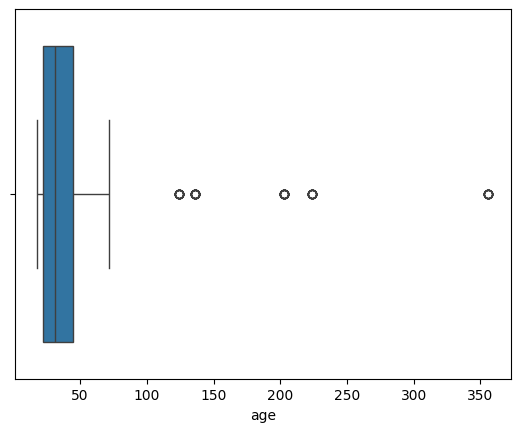

In [17]:
sns.boxplot(x=df['age'])
plt.show()